In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import math
import numpy as np
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2
import scipy.signal
import scipy.ndimage
import os
import sys
sys.path.append("../../")
import helpers
import mvs

%load_ext autoreload
%autoreload 2

# Extra Exercises (Distance Map Inpainting)
The previous exercises are enough to get you a passing grade. However, to get a $10$ you need to show that you have mastered the topic. Therefore, we introduce the following extra exercises which are considered a bit more challenging. You need to complete these without the help of the teaching assistants (TAs). **You not allowed to ask the TAs for help with the extra exercises**. However, you can report bugs by sending us an e-mail at `vdp-cs-ewi@tudelft.nl`.

## Distance Map Inpainting
Using epipolar lines and photo consistency functions we can compute for each pixel the distance from the camera to that point in space, which we'll call a *distance map*. However as you will have noticed from the previous exercises this map will contain some wrong distances (3D positions) due to incorrect matches. We might be able to detect these outliers, either by hand, or using an automated method (not discussed in this course) and use inpainting to find new distance values for these outlier pixels.

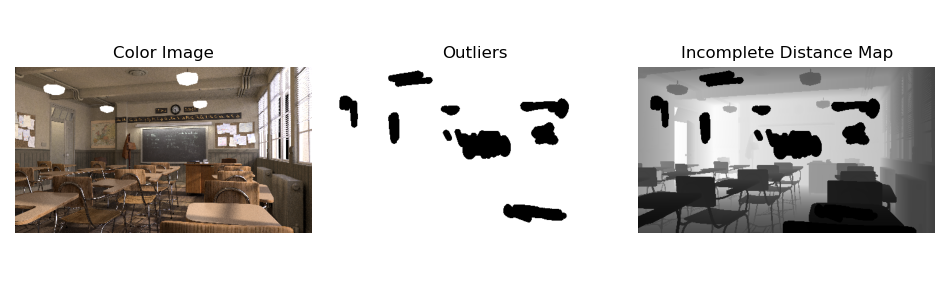

In [3]:
scale = 0.25
color_image = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "classroom_colors.png"), scale=scale, nn_interpolation=True)
mask = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "classroom_mask.png"), scale=scale, nn_interpolation=True)[:,:,0] < 0.5
incomplete_distance_map = helpers.imread_hdr(os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "classroom_incomplete_distance.exr"), scale=scale, nn_interpolation=True)[:,:,0]

helpers.show_images({
    "Color Image": color_image,
    "Outliers": mask,
    "Incomplete Distance Map": incomplete_distance_map,
}, nrows=1, ncols=3)

### Inpainting
Assuming that we know which pixels are outliers, we now want to find new values for these pixels. You have already worked on inpainting in the last assignment but this time we will use an optimization based technique.

Recall gradient-based image blending from the second assignment:
$$
\begin{align}
& \underset{U}{\text{minimize}}
& & f(U) = \sum\limits_{i \in I} {\lvert g_i - \tilde{g_i} \rvert}^2 + \alpha \sum\limits_{i \in B} {\lvert U - \tilde{U_t} \rvert}^2
\end{align}
$$

Where $U$ is a vector containing the output values, $g_i$ the gradients of those output values, $\tilde{g_i}$ the desired gradients, and $U_t$ the target image from which we take values on the boundary $B$ of the blending region.

When inpainting we do not know the best output gradients and instead we set them to zero ($\tilde{g_i}=0$). This has the effect that the values inside the inpainted region will vary smoothly between the boundary $B$. With this change the formula now becomes:

$$
\begin{align}
& \underset{U}{\text{minimize}}
& & f(U) = \sum\limits_{i \in I} {\lvert g_i \rvert}^2 + \alpha \sum\limits_{i \in B} {\lvert U - \tilde{U_t} \rvert}^2
\end{align}
$$

In assignment 2 the boundary was considered part of the blending region. However, for our inpainting algorithm we do not have access to any distance values at these pixels. Hence for inpainting we consider the boundary to contain pixels *outside* of the inpainting region rather than inside the region.

### Exercise 6 (1.5 points)
Implement the inpainting algorithm as described above. The mask indicates which pixels need to be filled in (where `mask[y,x]==0`). The mask is guaranteed to not touch the border of the image.

Steps:
* Find the formula to minimize $f(U)$, which is when $f'(U)=0$ (derivative is 0)
* Compute the vector $U_t$ containing the distance values at the boundary of the unknown region(s)
* Compute a gradient matrix $G$ for the unkown region
* Compute the selector matrix $S$ to select the boundary pixels from $U$
* Solve the linear system (1st step) using `scipy.sparse.linalg.spsolve(A, b)`
* Copy the values of the resulting vector $U$ back into the output image.

*Note*: You are allowed to reuse your own code from the second assignment.

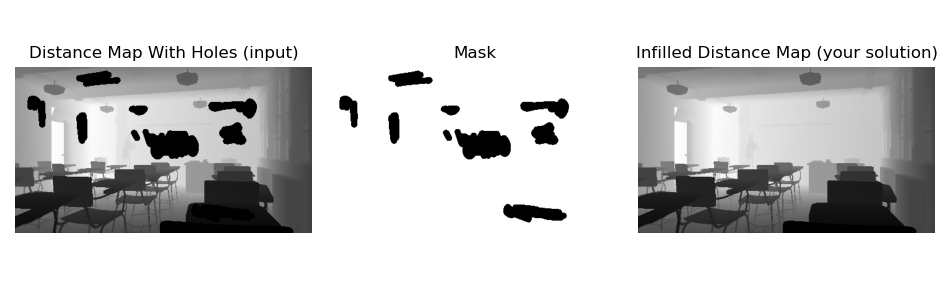

In [12]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import scipy.ndimage

def set_boundary_values_to_avg(infilled_distance_map, mask):
    h, w = infilled_distance_map.shape
    boundary_mask = scipy.ndimage.binary_dilation(mask) & ~mask
    boundary_indices = np.argwhere(boundary_mask)
    for y, x in boundary_indices:
        neighbors = [(y-1, x), (y+1, x), (y, x-1), (y, x+1)]
        valid_neighbors = []
        for ny, nx in neighbors:
            if 0 <= ny < h and 0 <= nx < w and mask[ny, nx] == 1:
                valid_neighbors.append(infilled_distance_map[ny, nx])
        if valid_neighbors:
            infilled_distance_map[y, x] = np.mean(valid_neighbors)
    return infilled_distance_map

def fill_in_mask_pixels(incomplete_distance_map, mask, alpha):
    h, w = incomplete_distance_map.shape
    infilled_distance_map = incomplete_distance_map.copy()
    infilled_distance_map = set_boundary_values_to_avg(infilled_distance_map, mask)
    inpainting_region = (mask == 0)
    boundary_mask = scipy.ndimage.binary_dilation(inpainting_region) & ~inpainting_region
    total_pixels = h * w
    index_map = np.arange(total_pixels).reshape(h, w)
    laplacian = scipy.sparse.lil_matrix((total_pixels, total_pixels), dtype=np.float32)
    b_full = np.zeros(total_pixels, dtype=np.float32)
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    for y in range(h):
        for x in range(w):
            if inpainting_region[y, x]:
                idx_p = index_map[y, x]
                laplacian[idx_p, idx_p] = 4.0
                for dy, dx_ in neighbors:
                    ny, nx = y + dy, x + dx_
                    if 0 <= ny < h and 0 <= nx < w:
                        if inpainting_region[ny, nx]:
                            idx_q = index_map[ny, nx]
                            laplacian[idx_p, idx_q] = -1.0
                        else:
                            val = infilled_distance_map[ny, nx]
                            b_full[idx_p] += val
                if boundary_mask[y, x]:
                    known_val = infilled_distance_map[y, x]
                    laplacian[idx_p, idx_p] += alpha
                    b_full[idx_p] += alpha * known_val
    I_indices = index_map[inpainting_region].flatten()
    G = laplacian[I_indices, :][:, I_indices].tocsc()
    b = b_full[I_indices]
    U_solution = scipy.sparse.linalg.spsolve(G, b)
    infilled_flat = infilled_distance_map.flatten()
    infilled_flat[I_indices] = U_solution
    infilled_distance_map = infilled_flat.reshape(h, w)
    return infilled_distance_map



complete_distance_map = fill_in_mask_pixels(incomplete_distance_map, mask, 0.5)

helpers.show_images({
    "Distance Map With Holes (input)": incomplete_distance_map,
    "Mask": mask,
    "Infilled Distance Map (your solution)": complete_distance_map
}, nrows=1, ncols=3)

### Test of exercise 6
The plot below creates a 3D representation of the image using your inpainted distance map. If the inpainting was successfull then there should be no holes where the outliers used to be (see "Infilled Distance Map" above).

In [ ]:
# Add your own tests here.

In [11]:
mvs.plot_point_cloud_from_distance_map(color_image, complete_distance_map)

In [ ]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL
